# Read Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
from fastai.tabular import * 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'
PATH_COVID = '/media/maria/2TB Monster driv/PrecisionFDA/LightGBM/COVID/'

In [2]:
from fastai.callbacks import *

# Read Data

In [3]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [4]:
nocovid  = pd.read_csv(PATH_COVID + 'no_covid_predicted.csv')

In [5]:
#Remove no covid
train = train.loc[train.COVID_Status == 1]
train.shape

(73697, 945)

In [6]:
oof_df = train[["Id", "Ventilator"]]

In [7]:
train.drop(columns=['COVID_Status', 'Hospitalized', 'Death', 'ICU', 'Id', 
                    'Days_hospitalized', 'Days_ICU', 'Death Certification'], inplace=True)  

In [8]:
#Display all database

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [9]:
display_all(train.describe())

DRIVERS  PASSPORT           LAT           LON  HEALTHCARE_EXPENSES  \
count  73697.0   73697.0  73697.000000  73697.000000         7.369700e+04   
mean       1.0       1.0     42.276641    -71.355158         9.958533e+05   
std        0.0       0.0      0.280952      0.594560         5.257319e+05   
min        1.0       1.0     41.241591    -73.490615         4.391440e+03   
25%        1.0       1.0     42.126691    -71.537896         6.186478e+05   
50%        1.0       1.0     42.316542    -71.153067         1.078231e+06   
75%        1.0       1.0     42.455546    -71.022418         1.440909e+06   
max        1.0       1.0     42.900027    -69.921561         3.203008e+06   

       HEALTHCARE_COVERAGE           Age  Allergy to bee venom  \
count         7.369700e+04  73697.000000           7545.000000   
mean          2.272775e+04     53.953974              0.190192   
std           5.957766e+04     18.640218              0.392479   
min           0.000000e+00     21.000000              0.000000   
25%           5.048600e+03     38.000000              0.000000   
50%           8.902250e+03     55.000000              0.000000   
75%           1.581682e+04     70.000000              0.000000   
max           1.557373e+06     84.000000              1.000000   

       Allergy to dairy product  Allergy to eggs  Allergy to fish  \
count               7545.000000      7545.000000      7545.000000   
mean                   0.038436         0.046918         0.183035   
std                    0.192259         0.211478         0.386721   
min                    0.000000         0.000000         0.000000   
25%                    0.000000         0.000000         0.000000   
50%                    0.000000         0.000000         0.000000   
75%                    0.000000         0.000000         0.000000   
max                    1.000000         1.000000         1.000000   

       Allergy to grass pollen  Allergy to mould  Allergy to nut  \
count              7545.000000       7545.000000     7545.000000   
mean                  0.278330          0.381975        0.180517   
std                   0.448206          0.485903        0.384643   
min                   0.000000          0.000000        0.000000   
25%                   0.000000          0.000000        0.000000   
50%                   0.000000          0.000000        0.000000   
75%                   1.000000          1.000000        0.000000   
max                   1.000000          1.000000        1.000000   

       Allergy to peanuts  Allergy to soya  Allergy to tree pollen  \
count         7545.000000      7545.000000             7545.000000   
mean             0.196024         0.017097                0.271040   
std              0.397013         0.129643                0.444526   
min              0.000000         0.000000                0.000000   
25%              0.000000         0.000000                0.000000   
50%              0.000000         0.000000                0.000000   
75%              0.000000         0.000000                1.000000   
max              1.000000         1.000000                1.000000   

       Allergy to wheat  Dander (animal) allergy  House dust mite allergy  \
count       7545.000000              7545.000000              7545.000000   
mean           0.043738                 0.353612                 0.268257   
std            0.204524                 0.478122                 0.443082   
min            0.000000                 0.000000                 0.000000   
25%            0.000000                 0.000000                 0.000000   
50%            0.000000                 0.000000                 0.000000   
75%            0.000000                 1.000000                 1.000000   
max            1.000000                 1.000000                 1.000000   

       Latex allergy  Shellfish allergy  Agreeing on diabetes care plan  \
count    7545.000000        7545.000000                    67162.000000   
mean    

# Training Neural Network 

In [10]:
procs = [FillMissing, Categorify, Normalize]

In [11]:
dep_var = 'Ventilator'
cat_names = ['DRIVERS' , 'PASSPORT', 'MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [12]:
PATH_data = PATH + 'Descriptive/'

In [13]:
#https://www.kaggle.com/dromosys/fast-ai-v1-focal-loss

from torch import nn
import torch.nn.functional as F

#Parameters of focal loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=5, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [14]:
# Setting random seed

SEED = 2019

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)


In [15]:
def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics,[metric])

In [16]:
len(test)

29492

In [17]:
#5 Fold cross-validation
nfold = 5
target = 'Ventilator'
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [18]:
train['Ventilator'].describe()

count    73697.000000
mean         0.057126
std          0.232084
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Ventilator, dtype: float64

In [19]:
test.shape

(29492, 938)

In [20]:
dep_var

'Ventilator'


fold 1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


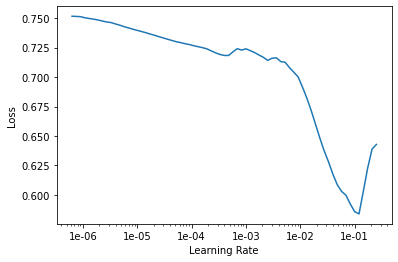

In [21]:
#Find Learning Rate
i = 1
cont_names = set(train) - set(cat_names) - {dep_var}

for train_index, valid_idx in skf.split(train, train.Ventilator.values):
    if i>1: 
        break
    print("\nfold {}".format(i))
    
    data= (TabularList.from_df(train, path=PATH_data, cat_names=cat_names, cont_names= cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=CategoryList)
                .databunch(bs=4096))
    
    
    learn = tabular_learner(data, layers=[3600, 1800], emb_drop=0.05, metrics=accuracy) #like rossmann
    
    learn.lr_find()
    learn.recorder.plot()
    i=i+1


In [22]:
i = 1
lr = 2e-2

for train_index, valid_idx in skf.split(train, train.Ventilator.values):
    print("\nfold {}".format(i))
    
    
    data = (TabularList.from_df(train, path=PATH_data, cat_names=cat_names, cont_names= cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=CategoryList)
                .add_test(TabularList.from_df(test, path=PATH_data, cat_names=cat_names, cont_names= cont_names))
                .databunch(bs=4096))
    
    learn = tabular_learner(data, layers=[3600, 1800], emb_drop=0.05, metrics=accuracy) #like rossmann
    
    learn.fit_one_cycle(15, slice(lr), callbacks=[AUROC(learn),SaveModelCallback(learn, every='improvement',
                                              monitor='valid_loss', name='bestmodel_ventilator_fold{}'.format(i))],
                        wd=0.1)
    
    
    
    learn.load('bestmodel_ventilator_fold{}'.format(i))
    interp = ClassificationInterpretation.from_learner(learn)
    from sklearn import metrics
    print(metrics.classification_report(interp.y_true.numpy(), interp.pred_class.numpy()))

    preds_valid = learn.get_preds(ds_type=DatasetType.Valid)
    predictions_v = []

    for j in range(len(valid_idx)):
        predictions_v.append(float(preds_valid[0][j][1].cpu().numpy()))
    
    oof[valid_idx] = predictions_v 
    
    preds = learn.get_preds(ds_type=DatasetType.Test)
    
    predictions_t = []

    for j in range(test.shape[0]):
        predictions_t.append(float(preds[0][j][1].cpu().numpy()))

    
    predictions += predictions_t 
    i = i + 1


fold 1


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,1.059444,0.629640,0.650407,0.635686,00:06
1,0.724431,0.311285,0.942334,0.635451,00:06
2,0.513763,0.444280,0.817368,0.754854,00:05
3,0.405658,0.250071,0.942877,0.655874,00:06
4,0.337044,0.197552,0.943487,0.759495,00:05
5,0.291160,0.201497,0.943691,0.772702,00:05
6,0.261977,135074.046875,0.941113,0.778117,00:05
7,0.243263,0.263539,0.943216,0.736622,00:05
8,0.226156,0.196025,0.943419,0.767983,00:05
9,0.212105,0.193134,0.942877,0.776827,00:06


Better model found at epoch 0 with valid_loss value: 0.6296396255493164.
Better model found at epoch 1 with valid_loss value: 0.31128501892089844.
Better model found at epoch 3 with valid_loss value: 0.250070720911026.
Better model found at epoch 4 with valid_loss value: 0.19755195081233978.
Better model found at epoch 8 with valid_loss value: 0.19602522253990173.
Better model found at epoch 9 with valid_loss value: 0.19313360750675201.


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13898
           1       0.50      0.03      0.05       842

    accuracy                           0.94     14740
   macro avg       0.72      0.51      0.51     14740
weighted avg       0.92      0.94      0.92     14740




fold 2


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,1.537062,79.876823,0.372592,0.655096,00:05
1,0.968131,67.193497,0.917300,0.620980,00:05
2,0.650684,0.292851,0.919742,0.762999,00:05
3,0.491142,0.212849,0.943012,0.770448,00:05
4,0.404295,0.239080,0.938331,0.770648,00:07
5,0.338380,0.202400,0.942198,0.789558,00:06
6,0.291612,0.222884,0.943216,0.778065,00:05
7,0.255334,0.228988,0.942130,0.758330,00:05
8,0.225754,0.239513,0.939756,0.756363,00:05
9,0.199016,0.265890,0.939552,0.701359,00:05


Better model found at epoch 0 with valid_loss value: 79.87682342529297.
Better model found at epoch 1 with valid_loss value: 67.19349670410156.
Better model found at epoch 2 with valid_loss value: 0.29285094141960144.
Better model found at epoch 3 with valid_loss value: 0.21284909546375275.
Better model found at epoch 5 with valid_loss value: 0.20239976048469543.


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13900
           1       0.43      0.04      0.08       840

    accuracy                           0.94     14740
   macro avg       0.69      0.52      0.52     14740
weighted avg       0.92      0.94      0.92     14740




fold 3


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,1.354576,0.580998,0.729493,0.406769,00:05
1,0.884190,186.733398,0.933103,0.721965,00:05
2,0.598749,628.845459,0.875636,0.766948,00:05
3,0.464659,0.307395,0.933238,0.711214,00:05
4,0.397902,3011.524902,0.432390,0.754736,00:05
5,0.336702,0.206792,0.944230,0.782878,00:05
6,0.293495,2311.746582,0.944365,0.773449,00:05
7,0.262590,14054.131836,0.943958,0.787104,00:05
8,0.240207,0.196911,0.944026,0.785722,00:05
9,0.222539,112502.320312,0.944026,0.778451,00:05


Better model found at epoch 0 with valid_loss value: 0.5809977650642395.
Better model found at epoch 3 with valid_loss value: 0.30739516019821167.
Better model found at epoch 5 with valid_loss value: 0.20679210126399994.
Better model found at epoch 8 with valid_loss value: 0.19691124558448792.


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13911
           1       0.54      0.02      0.04       828

    accuracy                           0.94     14739
   macro avg       0.74      0.51      0.51     14739
weighted avg       0.92      0.94      0.92     14739




fold 4


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,1.323541,30.862156,0.789742,0.590678,00:05
1,0.855182,0.247712,0.942262,0.684865,00:06
2,0.587304,0.504293,0.778343,0.751725,00:05
3,0.453595,8.744116,0.940430,0.774995,00:05
4,0.372668,1710.236694,0.934053,0.755434,00:05
5,0.331773,0.240755,0.937241,0.775497,00:06
6,0.293726,0.225896,0.942669,0.778702,00:05
7,0.261831,7376.519043,0.940905,0.785650,00:05
8,0.236227,11524.998047,0.942533,0.773863,00:05
9,0.214097,14046.451172,0.942126,0.749361,00:05


Better model found at epoch 0 with valid_loss value: 30.86215591430664.
Better model found at epoch 1 with valid_loss value: 0.24771207571029663.
Better model found at epoch 5 with valid_loss value: 0.24075454473495483.
Better model found at epoch 6 with valid_loss value: 0.2258959710597992.


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13889
           1       0.59      0.02      0.04       850

    accuracy                           0.94     14739
   macro avg       0.77      0.51      0.50     14739
weighted avg       0.92      0.94      0.92     14739




fold 5


epoch,train_loss,valid_loss,accuracy,AUROC,time
0,1.264932,12.573237,0.694620,0.594122,00:06
1,0.818912,20.187817,0.942126,0.650816,00:07
2,0.566278,368.486389,0.921636,0.735155,00:06
3,0.482314,0.580333,0.941923,0.482582,00:05
4,0.392850,1011.021057,0.839338,0.759214,00:05
5,0.331211,0.198278,0.942737,0.765574,00:06
6,0.290360,0.200849,0.942873,0.764728,00:05
7,0.260771,1950.818481,0.943212,0.768935,00:05
8,0.238860,2834.384521,0.943008,0.768998,00:05
9,0.222349,0.194419,0.943076,0.765554,00:05


Better model found at epoch 0 with valid_loss value: 12.573237419128418.
Better model found at epoch 3 with valid_loss value: 0.5803333520889282.
Better model found at epoch 5 with valid_loss value: 0.19827841222286224.
Better model found at epoch 9 with valid_loss value: 0.19441922008991241.


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13889
           1       0.67      0.03      0.05       850

    accuracy                           0.94     14739
   macro avg       0.81      0.51      0.51     14739
weighted avg       0.93      0.94      0.92     14739



In [23]:
print("\n\nCV AUC: {:<0.5f}".format(metrics.roc_auc_score(train.Ventilator.values.astype(bool), oof)))
print("\n\nCV log loss: {:<0.5f}".format(metrics.log_loss(train.Ventilator.values.astype(bool), oof)))
print("\n\nCV Gini: {:<0.5f}".format(2 * metrics.roc_auc_score(train.Ventilator.values.astype(bool), oof) -1))


#Cross entropy lr = 1e-2 CV AUC: 0.82524




CV AUC: 0.77433


CV log loss: 0.20000


CV Gini: 0.54865


In [24]:
#threshold optimization

maximum = 0
for i in range(1000):
    f1 = metrics.f1_score(train.Ventilator.values.astype(bool), oof >i*.001)
    if f1 > maximum:
        maximum=f1
        threshold =  i*0.001

print(f'Maximum f1 value: {maximum}' , f'Probability cutoff: {threshold}' )

Maximum f1 value: 0.25907990314769974 Probability cutoff: 0.117


In [25]:
print(metrics.classification_report(train.Ventilator.values.astype(bool), oof >threshold))

              precision    recall  f1-score   support

       False       0.96      0.92      0.94     69487
        True       0.20      0.36      0.26      4210

    accuracy                           0.88     73697
   macro avg       0.58      0.64      0.60     73697
weighted avg       0.92      0.88      0.90     73697



# Explanations

In [26]:
pred = oof

In [27]:
#code from https://forums.fast.ai/t/feature-importance-in-deep-learning/42026/6
def feature_importance(learner, cat_names, cont_names): 
  # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
        for i, c in enumerate(t):
            loss=[]
            for x,y in iter(learner.data.valid_dl):
                col=x[j][:,i]    #x[0] da hier cat-vars
                idx = torch.randperm(col.nelement())
                x[j][:,i] = col.view(-1)[idx].view(col.size())
                y=y.to('cpu')
                loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
            fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})

In [28]:
imp = feature_importance(learn, cat_names, cont_names)

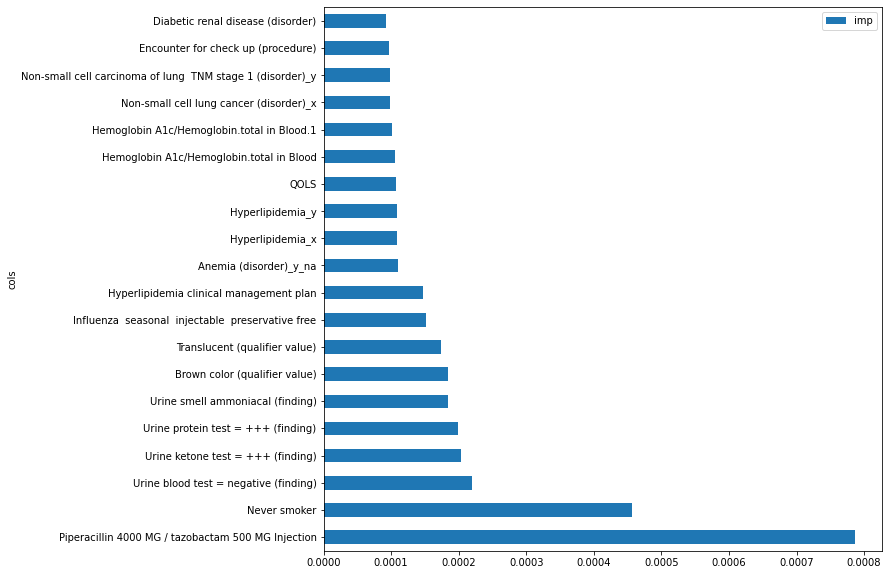

In [29]:
imp[:20].plot.barh(x="cols", y="imp", figsize=(10, 10))

In [30]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [31]:
fpr_rf, tpr_rf, _ = roc_curve(train.Ventilator.values.astype(bool), oof)

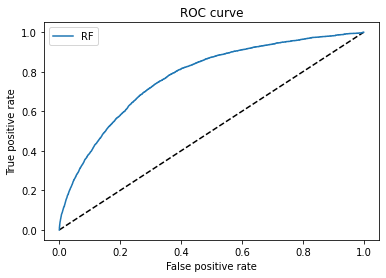

In [32]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [33]:
sub_df = pd.read_csv(PATH + 'Descriptive/test.csv')
sub_df["Ventilator"] = predictions/nfold

nocovid["COVID_flag"] = 0

sub_df = sub_df.merge(nocovid, how='left', left_on ='Id', right_on ='Id')
sub_df['COVID_flag'] = sub_df['COVID_flag'].fillna(1)

In [34]:


#If no covid all probabilities 0
sub_df["Ventilator"] = sub_df["Ventilator"] * sub_df['COVID_flag']
sub_df[['Id', 'Ventilator']].to_csv("NN_Ventilator_status.csv", index=False, line_terminator='\n', header=False)


In [35]:
np.mean(sub_df["Ventilator"]/nfold)

0.00691310769746501